# MODELOS PREDICTIVOS

En este caso se usará el dataset de Spotify con los datos ya preparados y limpios después de haber pasado por la revisión de calidad de datos.

Para las predicciones se usarán los modelos de Árbol de Decisiones, KNN, Red Neuronal, SVM y Random Forest. Para calificar la calidad de los modelos se usará una validación cruzada.

In [38]:
# Imports
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## PREPARACIÓN DE LOS DATOS

In [6]:
# Cargamos los datos desde el csv
data = pd.read_csv("spotify_prepared.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   danceability    195 non-null    float64
 1   loudness        195 non-null    float64
 2   speechiness     195 non-null    float64
 3   acousticness    195 non-null    float64
 4   valence         195 non-null    float64
 5   tempo           195 non-null    float64
 6   duration_ms     195 non-null    float64
 7   time_signature  195 non-null    int64  
 8   liked           195 non-null    int64  
dtypes: float64(7), int64(2)
memory usage: 13.8 KB


In [7]:
# Corrección de tipos de datos
data['time_signature']=data['time_signature'].astype('category')
data['liked']=data['liked'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   danceability    195 non-null    float64 
 1   loudness        195 non-null    float64 
 2   speechiness     195 non-null    float64 
 3   acousticness    195 non-null    float64 
 4   valence         195 non-null    float64 
 5   tempo           195 non-null    float64 
 6   duration_ms     195 non-null    float64 
 7   time_signature  195 non-null    category
 8   liked           195 non-null    category
dtypes: category(2), float64(7)
memory usage: 11.5 KB


<Axes: xlabel='liked'>

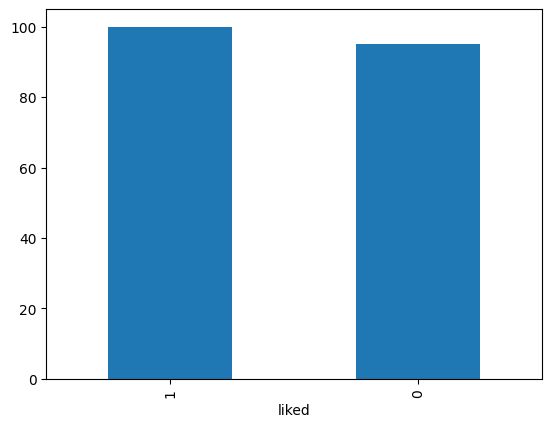

In [8]:
# Distribución de la variable objetivo
data['liked'].value_counts().plot(kind='bar')

In [9]:
# Se crean dummies en las variables categóricas
data_numeric = pd.get_dummies(data, columns=['time_signature'], drop_first=False, dtype=int)
data_numeric.head()

,danceability,loudness,speechiness,acousticness,valence,tempo,duration_ms,liked,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.803,-6.76400,0.0477,0.451,0.6280,95.968,304524.0,0,0,0,1,0
1,0.762,-7.95100,0.3060,0.206,0.5190,151.329,247178.0,1,0,0,1,0
2,0.261,-7.58488,0.0419,0.992,0.0382,75.296,286987.0,0,0,0,1,0
3,0.722,-6.99400,0.0585,0.431,0.5820,89.860,208920.0,1,0,0,1,0
4,0.787,-7.51600,0.2220,0.145,0.6470,155.117,179413.0,1,0,0,1,0


In [10]:
# LabelEncoder para la variable objetivo
labelencoder = LabelEncoder()
data_numeric['liked'] = labelencoder.fit_transform(data_numeric['liked'])

data_numeric

,danceability,loudness,speechiness,acousticness,valence,tempo,duration_ms,liked,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.803,-6.76400,0.0477,0.4510,0.6280,95.968,304524.0,0,0,0,1,0
1,0.762,-7.95100,0.3060,0.2060,0.5190,151.329,247178.0,1,0,0,1,0
2,0.261,-7.58488,0.0419,0.9920,0.0382,75.296,286987.0,0,0,0,1,0
3,0.722,-6.99400,0.0585,0.4310,0.5820,89.860,208920.0,1,0,0,1,0
4,0.787,-7.51600,0.2220,0.1450,0.6470,155.117,179413.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.166,-7.58488,0.0520,0.9760,0.1430,176.616,206520.0,0,0,1,0,0
191,0.862,-11.63000,0.0565,0.0192,0.8820,124.896,254240.0,0,0,0,1,0
192,0.499,-11.50900,0.0448,0.9510,0.6160,90.664,235947.0,0,0,0,1,0
193,0.574,-5.83800,0.0965,0.0406,0.4130,110.547,190239.0,1,0,0,0,1


## ENTRENAMIENTO Y EVALUCIÓN

### Configuración de validación cruzada

In [11]:
# Validación Cruzada
# Dataframe para comparar los modelos
comparacion_CV = pd.DataFrame()
scoring = ('f1', 'accuracy','precision', 'recall')
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # Muestreo estratificado

In [12]:
# Se separa variables predictoras y objetivo
X = data.drop("liked", axis = 1)
Y = data['liked']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   danceability    195 non-null    float64 
 1   loudness        195 non-null    float64 
 2   speechiness     195 non-null    float64 
 3   acousticness    195 non-null    float64 
 4   valence         195 non-null    float64 
 5   tempo           195 non-null    float64 
 6   duration_ms     195 non-null    float64 
 7   time_signature  195 non-null    category
dtypes: category(1), float64(7)
memory usage: 11.2 KB


In [13]:
# Se separa variables predictoras y objetivo para el dataset con dummies
X_num = data_numeric.drop("liked", axis = 1)
Y_num = data_numeric['liked']
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      195 non-null    float64
 1   loudness          195 non-null    float64
 2   speechiness       195 non-null    float64
 3   acousticness      195 non-null    float64
 4   valence           195 non-null    float64
 5   tempo             195 non-null    float64
 6   duration_ms       195 non-null    float64
 7   time_signature_1  195 non-null    int64  
 8   time_signature_3  195 non-null    int64  
 9   time_signature_4  195 non-null    int64  
 10  time_signature_5  195 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 16.9 KB


### Árbol de Decisiones

In [14]:
# Configuración de parámetros
modelTree = tree.DecisionTreeClassifier(criterion='gini', min_samples_leaf=200, max_depth=None)
# Validación cruzada
scores_tree = cross_validate(modelTree, X, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_tree = pd.DataFrame(scores_tree) # Se almacenan los resultados en un dataframe
# Se imprimen los resultados
scores_tree

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.010973,0.011913,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
1,0.001213,0.003404,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
2,0.000796,0.002828,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
3,0.000723,0.003138,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
4,0.000797,0.002901,0.666667,0.679245,0.500000,0.514286,0.500000,0.514286,1.0,1.0
5,0.000716,0.002790,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0
6,0.000729,0.002808,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0
7,0.000684,0.002669,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0
8,0.000664,0.002611,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0
9,0.000883,0.002733,0.689655,0.676692,0.526316,0.511364,0.526316,0.511364,1.0,1.0


In [15]:
# Modelo final Árbol
modelTree.fit(X, Y) # 100% de los datos

DecisionTreeClassifier(min_samples_leaf=200)

### KNN

In [23]:
# Normalizacion de las variables numéricas (Sin Dummies)
min_max_scaler = MinMaxScaler()
var_num=['loudness','tempo','duration_ms']
min_max_scaler.fit(X_num[var_num]) # Ajuste de los parametros: max - min
X_num[var_num]= min_max_scaler.transform(X_num[var_num])
X_num.head()

,danceability,loudness,speechiness,acousticness,valence,tempo,duration_ms,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.803,0.677236,0.0477,0.451,0.6280,0.298644,0.903787,0,0,1,0
1,0.762,0.590714,0.3060,0.206,0.5190,0.760506,0.668762,0,0,1,0
2,0.261,0.617401,0.0419,0.992,0.0382,0.126184,0.831914,0,0,1,0
3,0.722,0.660471,0.0585,0.431,0.5820,0.247687,0.511967,0,0,1,0
4,0.787,0.622421,0.2220,0.145,0.6470,0.792108,0.391037,0,0,1,0


In [27]:
# Configuración de parámetros
# Método Perezoso
modelKNN = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
# Validación cruzada
scores_knn = cross_validate(modelKNN, X_num, Y_num, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_knn = pd.DataFrame(scores_knn) # Se almacenan los resultados en un dataframe
# Se imprimen los resultados
scores_knn

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.009929,0.011017,0.909091,1.0,0.900000,1.0,0.833333,1.0,1.0,1.0
1,0.000874,0.004349,0.800000,1.0,0.800000,1.0,0.800000,1.0,0.8,1.0
2,0.000817,0.003255,0.952381,1.0,0.950000,1.0,0.909091,1.0,1.0,1.0
3,0.000781,0.003201,0.900000,1.0,0.900000,1.0,0.900000,1.0,0.9,1.0
4,0.000765,0.003069,0.947368,1.0,0.950000,1.0,1.000000,1.0,0.9,1.0
5,0.000902,0.003169,0.736842,1.0,0.736842,1.0,0.777778,1.0,0.7,1.0
6,0.000789,0.003715,0.909091,1.0,0.894737,1.0,0.833333,1.0,1.0,1.0
7,0.000737,0.003269,0.842105,1.0,0.842105,1.0,0.888889,1.0,0.8,1.0
8,0.000723,0.003989,0.952381,1.0,0.947368,1.0,0.909091,1.0,1.0,1.0
9,0.000747,0.003369,0.736842,1.0,0.736842,1.0,0.777778,1.0,0.7,1.0


In [28]:
# Modelo final KNN
modelKNN.fit(X_num, Y_num) # 100% de los datos

KNeighborsClassifier(metric='euclidean', n_neighbors=1)

### Red Neuronal

In [29]:
# Configuración de parámetros
# Solo se configura capas ocultas, no se configura capa de entrada y de salida
modelNN = MLPClassifier(activation="logistic",hidden_layer_sizes=(5), learning_rate='constant',
                     learning_rate_init=0.2, momentum= 0.3, max_iter=500, random_state=3)
# Validación cruzada
scores_nn = cross_validate(modelNN, X_num, Y_num, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_nn = pd.DataFrame(scores_nn)
# Se imprimen los resultados
scores_nn

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.076392,0.003068,0.952381,1.0,0.950000,1.0,0.909091,1.0,1.0,1.0
1,0.028832,0.002793,0.842105,1.0,0.850000,1.0,0.888889,1.0,0.8,1.0
2,0.038293,0.003089,0.842105,1.0,0.850000,1.0,0.888889,1.0,0.8,1.0
3,0.039518,0.004265,0.900000,1.0,0.900000,1.0,0.900000,1.0,0.9,1.0
4,0.037606,0.003286,0.900000,1.0,0.900000,1.0,0.900000,1.0,0.9,1.0
5,0.037832,0.003178,0.947368,1.0,0.947368,1.0,1.000000,1.0,0.9,1.0
6,0.040321,0.003120,0.900000,1.0,0.894737,1.0,0.900000,1.0,0.9,1.0
7,0.032913,0.002808,0.777778,1.0,0.789474,1.0,0.875000,1.0,0.7,1.0
8,0.033551,0.002892,0.869565,1.0,0.842105,1.0,0.769231,1.0,1.0,1.0
9,0.029693,0.003577,0.900000,1.0,0.894737,1.0,0.900000,1.0,0.9,1.0


In [30]:
# Modelo final Red Neuronal
modelNN.fit(X_num, Y_num) # 100% de los datos

MLPClassifier(activation='logistic', hidden_layer_sizes=5,
              learning_rate_init=0.2, max_iter=500, momentum=0.3,
              random_state=3)

### SVM

In [31]:
# Configuración de parámetros
modelSVM = SVC(kernel='linear') #'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
# Validación cruzada
scores_svm = cross_validate(modelSVM, X_num, Y_num, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_svm = pd.DataFrame(scores_svm)
# Se imprimen los resultados
scores_svm

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.004934,0.009267,0.952381,0.902174,0.950000,0.897143,0.909091,0.882979,1.0,0.922222
1,0.001744,0.004126,0.900000,0.912088,0.900000,0.908571,0.900000,0.902174,0.9,0.922222
2,0.001517,0.003654,0.818182,0.898396,0.800000,0.891429,0.750000,0.865979,0.9,0.933333
3,0.001215,0.003539,0.900000,0.912088,0.900000,0.908571,0.900000,0.902174,0.9,0.922222
4,0.001203,0.003005,0.900000,0.901099,0.900000,0.897143,0.900000,0.891304,0.9,0.911111
5,0.001266,0.003110,0.947368,0.902174,0.947368,0.897727,1.000000,0.882979,0.9,0.922222
6,0.001018,0.002538,0.857143,0.900000,0.842105,0.897727,0.818182,0.900000,0.9,0.900000
7,0.001161,0.002703,0.947368,0.891304,0.947368,0.886364,1.000000,0.872340,0.9,0.911111
8,0.001071,0.002820,0.857143,0.912088,0.842105,0.909091,0.818182,0.902174,0.9,0.922222
9,0.001024,0.002453,0.900000,0.902174,0.894737,0.897727,0.900000,0.882979,0.9,0.922222


In [32]:
# Modelo final SVM
modelSVM.fit(X_num, Y_num) # 100% de los datos

SVC(kernel='linear')

### Random Forest

In [ ]:
# Configuración de parámetros
modelRF = RandomForestClassifier(n_estimators=100,  max_samples=0.7, criterion='gini',
                              max_depth=None, min_samples_leaf=2)
# Validación cruzada
scores_rf = cross_validate(modelRF, X, Y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=False)
scores_rf = pd.DataFrame(scores_rf)
# Se imprimen los resultados
scores_rf

,fit_time,score_time,test_f1,train_f1,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall
0,0.147234,0.006177,0.952381,0.977778,0.950000,0.977143,0.909091,0.977778,1.0,0.977778
1,0.048476,0.005256,0.909091,0.977778,0.900000,0.977143,0.833333,0.977778,1.0,0.977778
2,0.057049,0.005752,0.952381,0.978022,0.950000,0.977143,0.909091,0.967391,1.0,0.988889
3,0.058587,0.005338,0.900000,0.978022,0.900000,0.977143,0.900000,0.967391,0.9,0.988889
4,0.050939,0.006082,0.952381,0.972376,0.950000,0.971429,0.909091,0.967033,1.0,0.977778
5,0.051151,0.005105,0.947368,0.983425,0.947368,0.982955,1.000000,0.978022,0.9,0.988889
6,0.047822,0.005051,0.888889,0.966667,0.894737,0.965909,1.000000,0.966667,0.8,0.966667
7,0.047947,0.004964,0.947368,0.977778,0.947368,0.977273,1.000000,0.977778,0.9,0.977778
8,0.050601,0.005753,0.869565,0.977778,0.842105,0.977273,0.769231,0.977778,1.0,0.977778
9,0.050758,0.005397,0.947368,0.983240,0.947368,0.982955,1.000000,0.988764,0.9,0.977778


In [34]:
# Modelo final Random Forest
modelRF.fit(X, Y) # 100% de los datos

RandomForestClassifier(max_samples=0.7, min_samples_leaf=2)

## COMPARACIÓN
A continuación se hará la comparación de los resultados obtenidos de todos los modelos para definir cuál fue el mejor, esta comparación se hará sacando los promedios de Precisión, Recall y F1, y luego llevándolos a una tabla para facilitar la lectura.

In [36]:
# Se crea un diccionario para almacenar los resultados promedio de cada modelo
resultados = {
    'Modelo': ['Árbol de Decisiones', 'KNN', 'Red Neuronal', 'SVM', 'Random Forest'],
    'Recall Promedio': [],
    'Precisión Promedio': [],
    'F1 Promedio': []
}

# Lista de los DataFrames de resultados de cada modelo
scores_list = [
    scores_tree,
    scores_knn,
    scores_nn,
    scores_svm,
    scores_rf
]

# Calcular los promedios y agregarlos al diccionario
for scores in scores_list:
    resultados['Recall Promedio'].append(scores['test_recall'].mean())
    resultados['Precisión Promedio'].append(scores['test_precision'].mean())
    resultados['F1 Promedio'].append(scores['test_f1'].mean())

# Crear un DataFrame para mostrar los resultados
tabla_comparacion = pd.DataFrame(resultados)

# Mostrar la tabla
print(tabla_comparacion)

                Modelo  Recall Promedio  Precisión Promedio  F1 Promedio
0  Árbol de Decisiones             1.00            0.513158     0.678161
1                  KNN             0.88            0.862929     0.868610
2         Red Neuronal             0.88            0.893110     0.883130
3                  SVM             0.91            0.889545     0.897959
4        Random Forest             0.94            0.922984     0.926679


Como se puede ver, los resultados de KNN, NN, SVM y Random Forest son similares, mientras que los del Árbol son un poco confusos y no tan buenos, sin embargo se puede apuntar a un ganador claro que es el Random Forest, supera a los demás en todas las métricas por lo cual, es el que se usará para la hiperparametrización y el despliegue.

## HIPERPARAMETRIZACIÓN

In [39]:
# Configuración de validación cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definir los hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],  # Cantidad de árboles
    'max_samples': [0.7],            # Proporción de muestras
    'criterion': ['gini', 'entropy'], # Criterios de división
    'max_depth': [None, 10, 20, 50], # Profundidad máxima
    'min_samples_leaf': [2, 10, 50, 100] # Mínimo de muestras por hoja
}

# Crear el modelo base
modelRF2 = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV
grid = GridSearchCV(
    estimator=modelRF2,
    param_grid=param_grid,
    scoring='f1',  # Métrica de evaluación
    cv=cv,
    n_jobs=-1,     # Usar todos los núcleos disponibles
    verbose=1      # Mostrar progreso
)

# Ajustar el modelo
grid.fit(X, Y)

# Mejor modelo y resultados
modelRF2 = grid.best_estimator_
print("Mejores parámetros:", grid.best_params_)
print("Mejor puntuación F1:", grid.best_score_)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Mejores parámetros: {'criterion': 'entropy', 'max_depth': None, 'max_samples': 0.7, 'min_samples_leaf': 2, 'n_estimators': 200}
Mejor puntuación F1: 0.9473825869020377


## SE GUARDA EL MODELO PARA DESPLIEGUE
Se guarda el modelo de Random Forest en un archivo de Pickle para ser usado en el Notebook de despliegue.

In [40]:
filename = 'RandomForest.pkl'
variables= X.columns._values
pickle.dump([modelRF2, labelencoder, variables], open(filename, 'wb'))